In [1]:
import os
import cv2
import sys
import PIL
import pathlib
import PIL.Image
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import class_weight
from tensorflow.keras import layers as L
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

import matplotlib.pyplot as plt
%matplotlib inline

from utils import *

In [73]:
import shutil
import os
import time

for i in range(9, 16):
    source = f"data/train_by_type/2/{i}/"
    destination = "data/train_by_type/2"
    files_list = os.listdir(source)
    for files in files_list:
        shutil.move(source + files, destination + f"/{time.time()}.jpg")

In [28]:
# for count, filename in enumerate(os.listdir("data/train_by_type")):
#     dst = f"data/{count + 1}.MOV"
#     src = f"data/{filename}"
#     os.mkdir(f"data/{count + 1}")

#     # os.rename(src, dst)

In [7]:
def resizeAndPad(img, size, padColor=0):

    h, w = img.shape[:2]
    sh, sw = size

    # interpolation method
    if h > sh or w > sw: # shrinking image
        interp = cv2.INTER_AREA
    else: # stretching image
        interp = cv2.INTER_CUBIC

    # aspect ratio of image
    aspect = w/h  # if on Python 2, you might need to cast as a float: float(w)/h

    # compute scaling and pad sizing
    if aspect > 1: # horizontal image
        new_w = sw
        new_h = np.round(new_w/aspect).astype(int)
        pad_vert = (sh-new_h)/2
        pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
        pad_left, pad_right = 0, 0
    elif aspect < 1: # vertical image
        new_h = sh
        new_w = np.round(new_h*aspect).astype(int)
        pad_horz = (sw-new_w)/2
        pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
        pad_top, pad_bot = 0, 0
    else: # square image
        new_h, new_w = sh, sw
        pad_left, pad_right, pad_top, pad_bot = 0, 0, 0, 0

    # set pad color
    if len(img.shape) == 3 and not isinstance(padColor, (list, tuple, np.ndarray)): # color image but only one color provided
        padColor = [padColor]*3

    # scale and pad
    scaled_img = cv2.resize(img, (new_w, new_h), interpolation=interp)
    scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=padColor)

    return scaled_img

def resize(img):
    height, width, channels = img.shape
    x = height if height > width else width
    y = height if height > width else width
    square= np.zeros((x,y,3), np.uint8)

    square[int((y-height)/2):int(y-(y-height)/2), int((x-width)/2):int(x-(x-width)/2)] = img

    return square

In [14]:
octr = 1

for count, filename in enumerate(sorted(Path("data/").iterdir(), key=os.path.getmtime)):
    filename = filename.name
    if "." in filename and "1.MOV" != filename:
      if filename == "2.MOV":
        src = f"data/{filename}"
        cap = cv2.VideoCapture(src)
        ct = 0
        octr += 1
        print(filename)
        while cap.isOpened():
          try:
            file_name = f"data/train/{octr}/{ct}.jpg"
            ret, img = cap.read()
            m = (img.shape[1] - img.shape[0]) // 2

            img = img[:, m:img.shape[1]-m]

            img = cv2.resize(img, (75, 75))

            
            cv2.imwrite(file_name, img)
            # cv2.imshow('frame', img)
            # if cv2.waitKey(1) & 0xFF == ord('q'):
            #   break

            ct += 1
          except KeyboardInterrupt:
            break
          except:
            break

cap.release()
cv2.destroyAllWindows()

2.MOV


In [78]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
        'data/train_by_type',
        target_size=(75, 75),
        batch_size=32,
        class_mode='categorical')

Found 19555 images belonging to 4 classes.


In [2]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_ds = image_dataset_from_directory("data/train_by_type", image_size=(75, 75), validation_split=0.1,
  subset="training", seed=123, batch_size=32)

val_ds = image_dataset_from_directory("data/train_by_type", image_size=(75, 75), validation_split=0.1,
  subset="validation", seed=123, batch_size=32)

Found 19555 files belonging to 4 classes.
Using 17600 files for training.
Found 19555 files belonging to 4 classes.
Using 1955 files for validation.


In [75]:
class_names = train_ds.class_names
class_names

['1', '2', '3', '4']

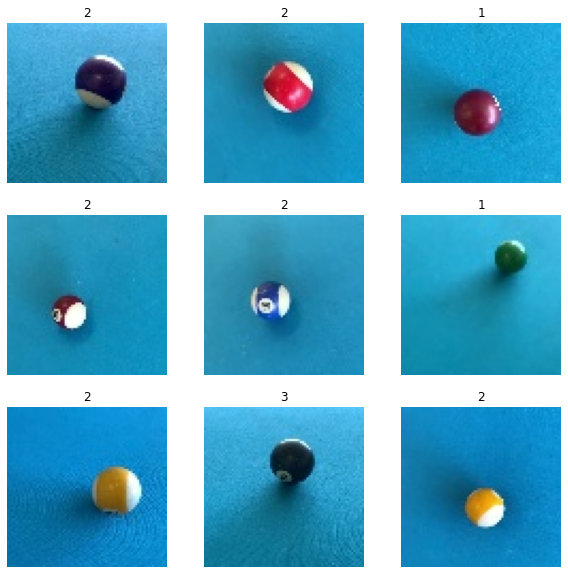

In [76]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [77]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 75, 75, 3)
(32,)


In [28]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalization_layer

In [32]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[1]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [5]:
num_classes = 4

class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_ds.class_names), 
            train_ds.class_names)
train_class_weights = dict(enumerate(class_weights))

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255))
model.add(tf.keras.applications.resnet50.ResNet50(input_shape = (75, 75, 3),
                                pooling = 'avg',
                                include_top = False, 
                                weights = 'imagenet'))

model.add(L.Flatten())
model.add(L.Dense(128, activation='relu'))
model.add(L.Dense(num_classes, activation='softmax'))

model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.build((None, 75, 75, 3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 75, 75, 3)         0         
_________________________________________________________________
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               262272    
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 516       
Total params: 23,850,500
Trainable params: 23,797,380
Non-trainable params: 53,120
_________________________________________________________________


In [7]:
model.fit(train_ds, validation_data=val_ds, epochs=2, class_weight=train_class_weights)

Epoch 1/3
550/550 [==============================] - 30s 54ms/step - loss: 0.0215 - accuracy: 0.9944 - val_loss: 1.5510 - val_accuracy: 0.3217
Epoch 2/3
550/550 [==============================] - 29s 52ms/step - loss: 0.0078 - accuracy: 0.9985 - val_loss: 6.3441e-05 - val_accuracy: 1.0000
Epoch 3/3
550/550 [==============================] - 29s 53ms/step - loss: 0.0060 - accuracy: 0.9989 - val_loss: 4.7796e-06 - val_accuracy: 1.0000


In [12]:
DECODER_DICT = {
    2: 11,
    7: 16,
    11: 5,
    4: 13,
    9: 3,
    8: 2,
    12: 6,
    6: 15,
    4: 13,
    0: 1,
    3: 12,
    10: 4,
    15: 9,
    1: 10,
    14: 8,
    5: 14,
    13: 7,
}

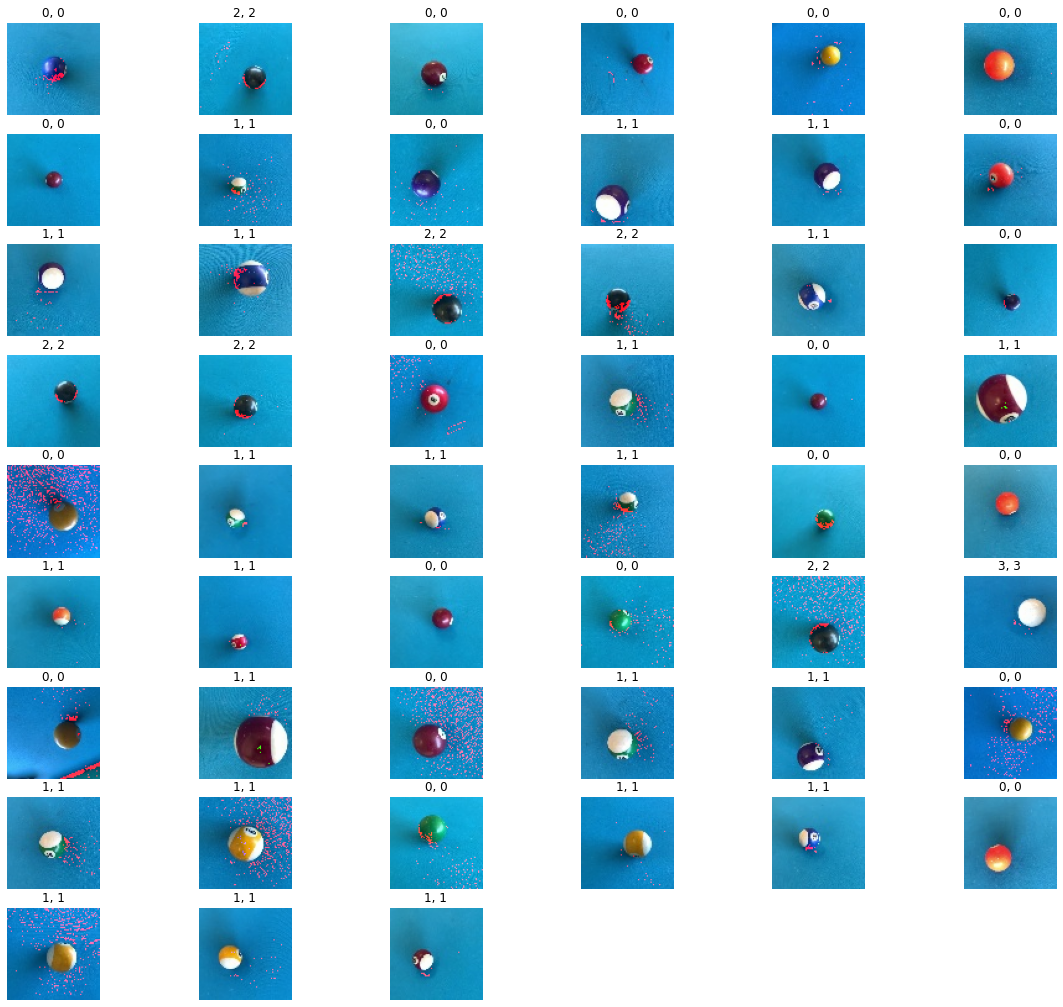

In [8]:
plt.figure(figsize=(20, 20))
ct = 0
for x in val_ds:

    xi, yi = x
    pi = model.predict_on_batch(xi)
    for img, label, prediction in zip(xi, yi, pi):
        if ct > 50:
            break
        prediction = np.argmax(prediction)
        img = 255 - (np.array(list(img)) * 255).astype(np.uint8)
        plt.subplot(10, 6, ct + 1)
        
        plt.imshow(img)
        plt.title(f"{prediction}, {int(label)}")
        plt.axis("off")
        ct += 1


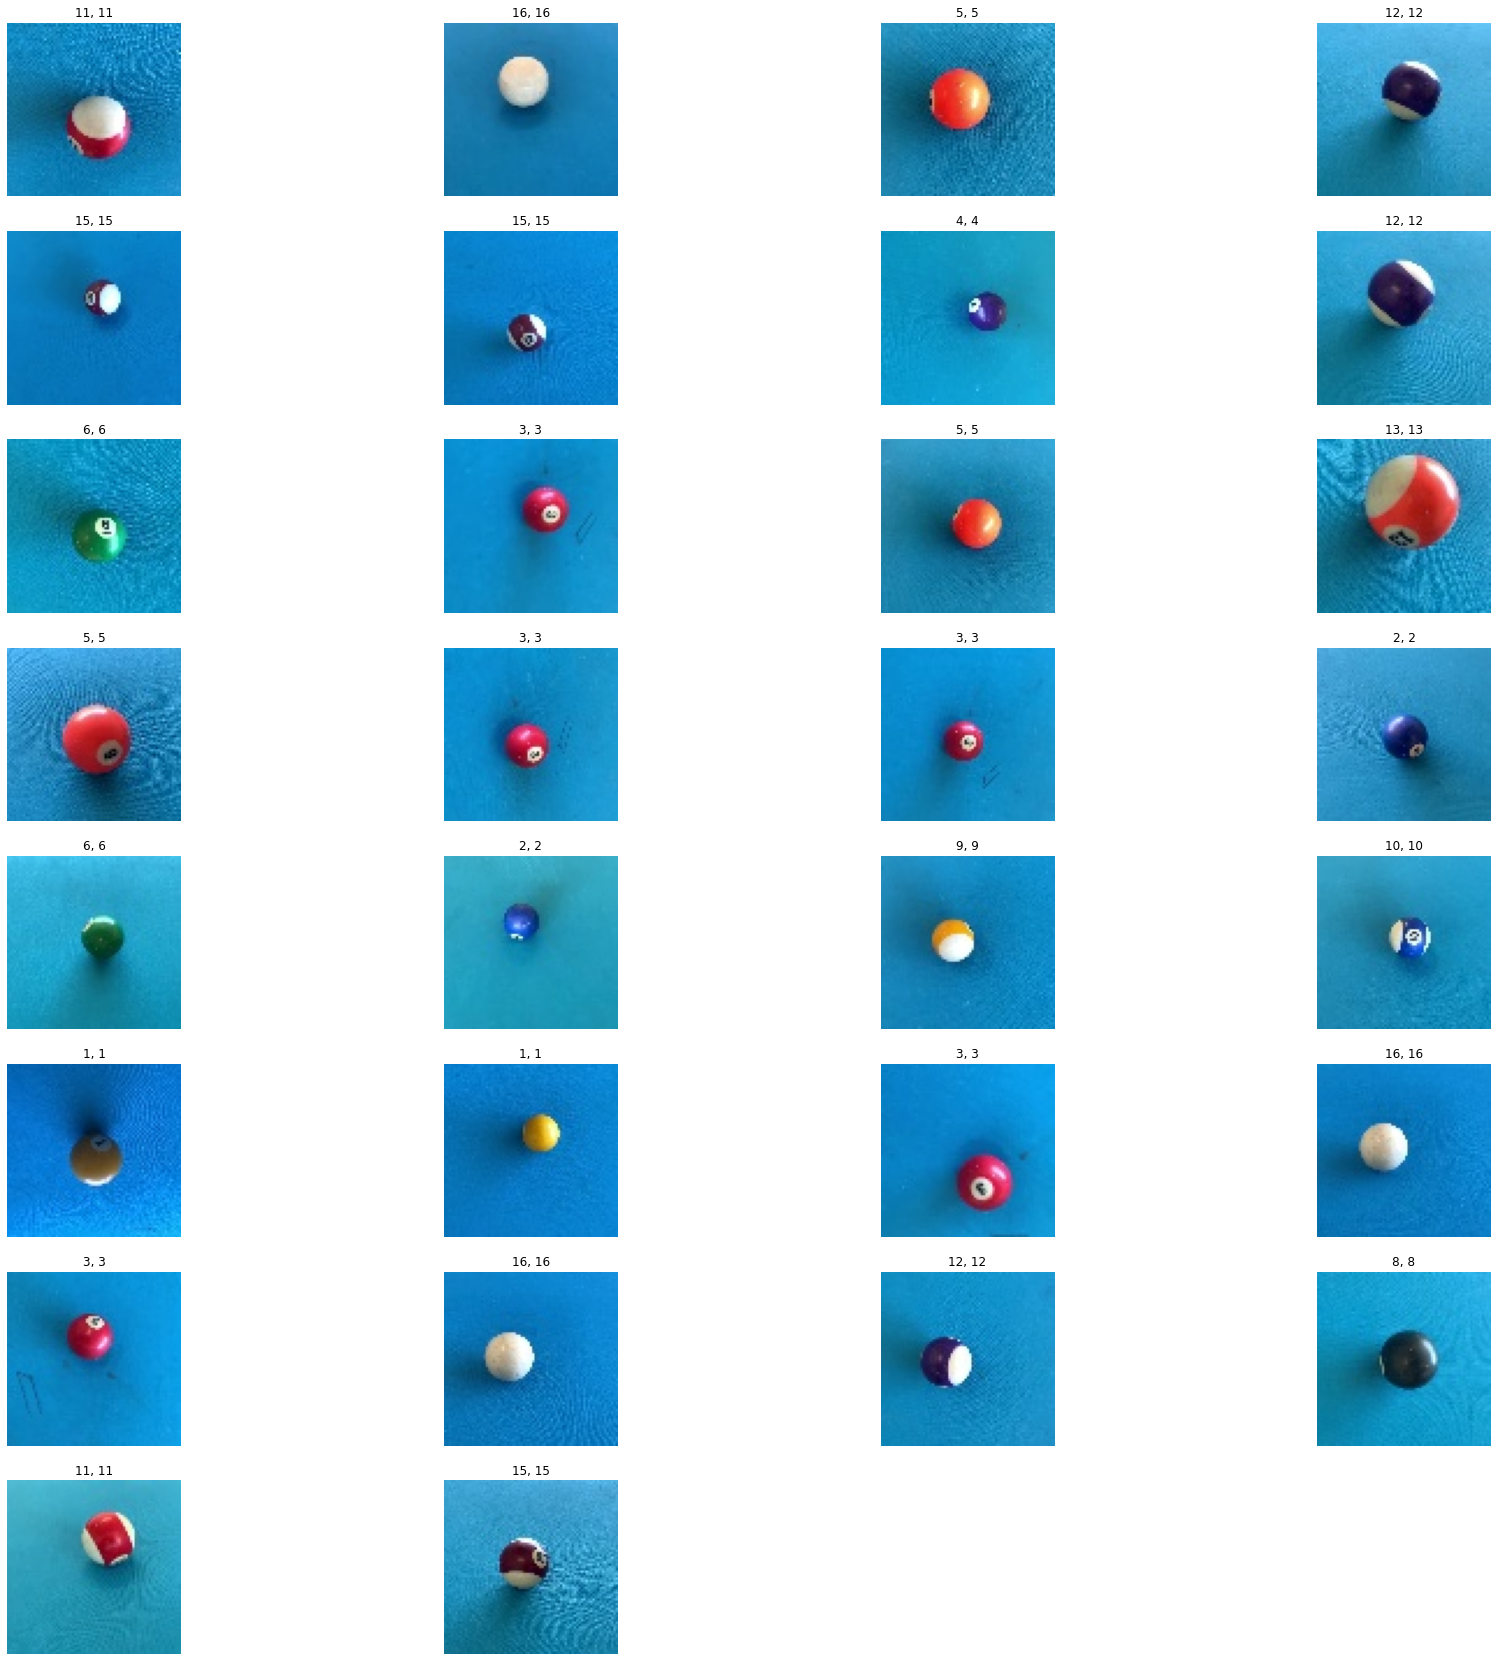

In [252]:
plt.figure(figsize=(30, 30))
for images, labels in train_ds.take(1):
    for i in range(30):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(str(class_names[labels[i]]) + ", " + str(DECODER_DICT[np.argmax(model.predict(np.expand_dims(images[i], axis=0)))]))
        plt.axis("off")

In [9]:
checkpoint_path = "models/ball.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [10]:
model.save_weights(checkpoint_path)
# tf.keras.models.save_model(model, os.path.join(checkpoint_dir, 'model.h5'))

In [17]:
new_model = tf.keras.models.load_model(os.path.join(checkpoint_dir, 'model.h5'))

In [18]:
new_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_10 (Rescaling)     (None, 75, 75, 3)         0         
_________________________________________________________________
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten_9 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               262272    
_________________________________________________________________
dense_19 (Dense)             (None, 16)                2064      
Total params: 23,852,048
Trainable params: 23,798,928
Non-trainable params: 53,120
_________________________________________________________________


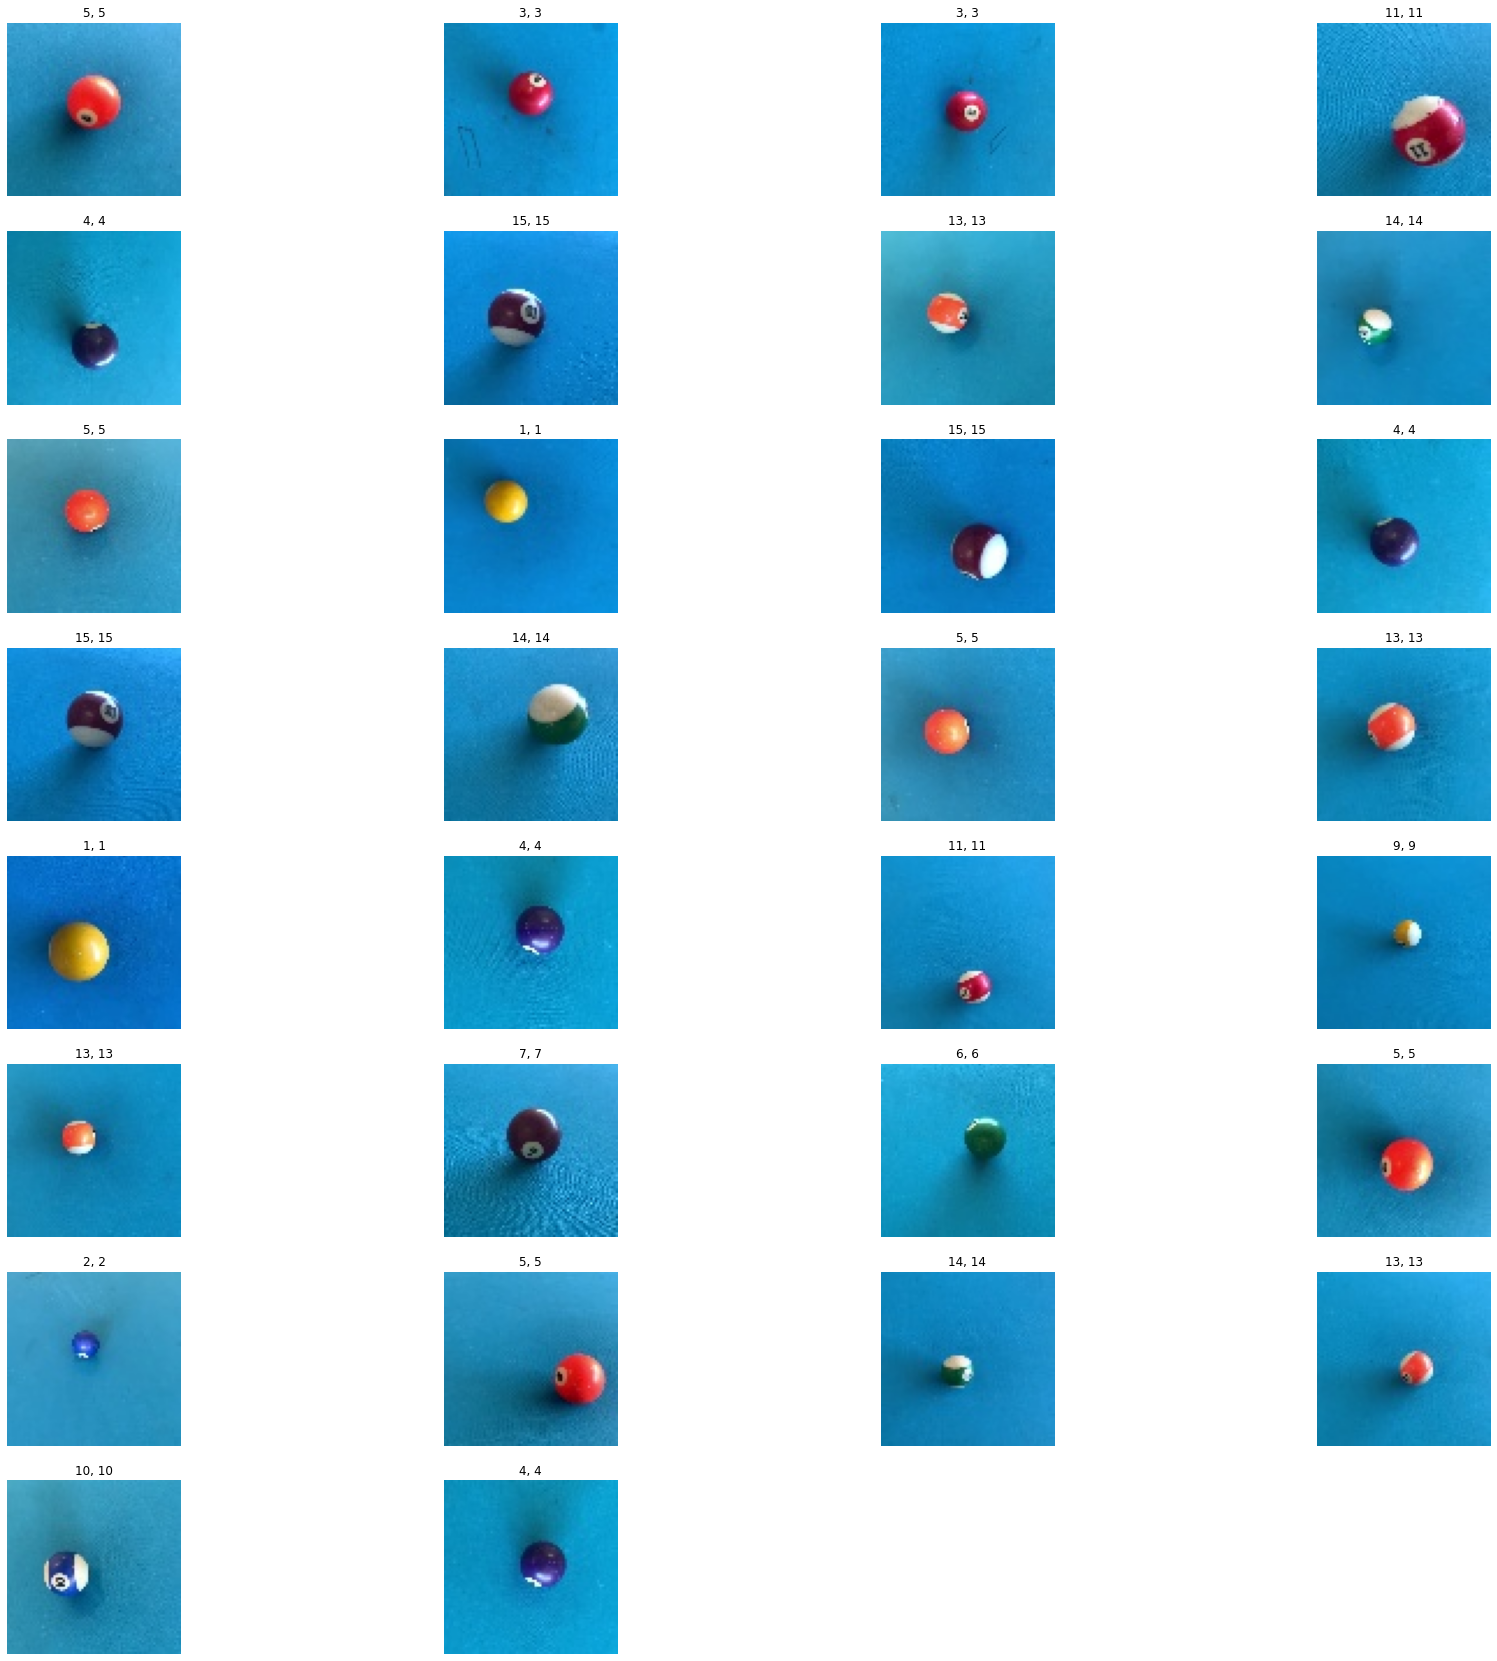

In [19]:
plt.figure(figsize=(30, 30))
for images, labels in val_ds.take(1):
    for i in range(30):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(str(class_names[labels[i]]) + ", " + str(DECODER_DICT[np.argmax(new_model.predict(np.expand_dims(images[i], axis=0)))]))
        plt.axis("off")

9


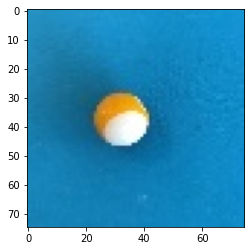

In [27]:
im = cv2.imread("data/train/9/247.jpg")
im = cv2.cvtColor(cv2.resize(im, (75, 75)), cv2.COLOR_BGR2RGB)
plt.imshow(im)
print(DECODER_DICT[np.argmax(new_model.predict(np.expand_dims(im, axis=0)))])
cv2.destroyAllWindows()